In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=439a8d26eb293ef19320066ec4012a71747f1433dd597f9a2f587782571ad401
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [3]:
from medmnist import OCTMNIST
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n\nDevice:", device, "\n\n")



Device: cuda 




In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
training_octset = OCTMNIST(root='/content/drive/MyDrive/Colab Notebooks',split='train', download=True, transform = transform)
validation_octset = OCTMNIST(root='/content/drive/MyDrive/Colab Notebooks',split='val', download=True, transform = transform)
testing_octset = OCTMNIST(root='/content/drive/MyDrive/Colab Notebooks',split='test', download=True, transform = transform)
print(training_octset)

Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/octmnist.npz
Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/octmnist.npz
Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/octmnist.npz
Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: /content/drive/MyDrive/Colab Notebooks
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validatio

In [6]:
octset = torch.utils.data.ConcatDataset([training_octset,validation_octset,testing_octset])
training, test = train_test_split(octset, random_state=42, test_size=0.15)
train, validation = train_test_split(training, random_state=42, test_size=0.15)

In [7]:
batch_size = 4
trainOctloader = torch.utils.data.DataLoader(training, batch_size=batch_size, shuffle=True)
testOctloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
valOctloader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=False)

In [8]:
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')

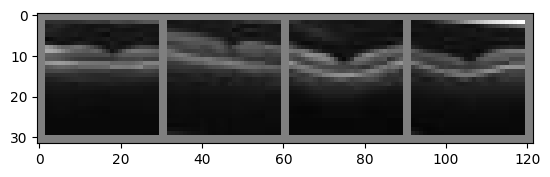

drusen ,diabetic macular edema ,normal ,normal


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npyimg = img.numpy()
    plt.imshow(np.transpose(npyimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainOctloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' ,'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Base Model

In [10]:
class CNN_model(nn.Module):
    def __init__(self, channels, classes):
        super().__init__()+
        self.conv1 = nn.Conv2d(channels, 96, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 200, 3)
        self.conv3 = nn.Conv2d(200, 280, 3)
        self.fc1 = nn.Linear(280 * 1 * 1, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

channels = 1
classes = 4
mymodel = CNN_model(channels,classes)

In [11]:
mymodel_criterion = nn.CrossEntropyLoss()
mymodel_optimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9)
mymodel.to(device)

CNN_model(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 280, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=280, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
)

In [12]:
mymodel_start_time = time.time()
mymodel_train_accuracy_arr = []
mymodel_train_loss_arr = []
mymodel_validation_accuracy_arr = []
mymodel_validation_loss_arr = []
epochs = 10
epochs_run_counter = 0
mymodel_total_validation_loss = 0.0
mymodel_running_loss = 0.0
for epoch in range(epochs):
    # Training
    mymodel_total_train_loss = 0.0
    mymodel_correct_train = 0
    mymodel_total_train = 0
    mymodel.train()
    for i,data in enumerate(trainOctloader):
        inputs,labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel_optimizer.zero_grad()
        mymodel_outputs = mymodel(inputs)
        mymodel_loss = mymodel_criterion(mymodel_outputs, labels)
        mymodel_loss.backward()
        mymodel_optimizer.step()
        mymodel_running_loss += mymodel_loss.item()
        _, predicted = torch.max(mymodel_outputs.data, 1)
        mymodel_total_train += labels.size(0)
        mymodel_correct_train += (predicted == labels).sum().item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {mymodel_running_loss / 2000:.3f}')
            mymodel_running_loss = 0.0
    mymodel_total_train_loss = mymodel_running_loss*100 /mymodel_total_train
    mymodel_train_loss_arr.append(mymodel_total_train_loss)
    mymodel_train_accuracy = mymodel_correct_train*100 / mymodel_total_train
    mymodel_train_accuracy_arr.append(mymodel_train_accuracy)
    print(f'Epoch [{epoch+1}], Train Loss: {mymodel_total_train_loss:.4f}, Train Accuracy: {mymodel_train_accuracy:.4f}')
    # validation
    mymodel_correct_validation = 0
    mymodel_val_running_loss = 0.0
    mymodel_total_validation_loss = 0.0
    mymodel_total_val = 0
    mymodel.eval()
    with torch.no_grad():
        for i,data in enumerate(valOctloader):
            inputs,labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze(1).long()
            mymodel_outputs = mymodel(inputs)
            mymodel_loss = mymodel_criterion(mymodel_outputs, labels)
            _, predicted = torch.max(mymodel_outputs.data, 1)
            mymodel_correct_validation += (predicted == labels).sum().item()
            mymodel_val_running_loss += mymodel_loss.item()
            mymodel_total_val += labels.size(0)
    mymodel_total_validation_loss = mymodel_val_running_loss*100/ mymodel_total_val
    mymodel_validation_accuracy = mymodel_correct_validation*100 / mymodel_total_val
    mymodel_validation_accuracy_arr.append(mymodel_validation_accuracy)
    mymodel_validation_loss_arr.append(mymodel_total_validation_loss)
    print(f'Epoch [{epoch+1}], Validation Loss: {mymodel_total_validation_loss:.4f}, Validation Accuracy: {mymodel_validation_accuracy:.4f}')
    epochs_run_counter+=1

print('Finished Training')
mymodel_end_time = time.time()
mymodel_training_time = mymodel_end_time-mymodel_start_time
print(f"Time to train: {mymodel_training_time} seconds")

[1,  2000] training loss: 1.169
[1,  4000] training loss: 1.141
[1,  6000] training loss: 0.877
[1,  8000] training loss: 0.779
[1, 10000] training loss: 0.710
[1, 12000] training loss: 0.656
[1, 14000] training loss: 0.601
[1, 16000] training loss: 0.570
[1, 18000] training loss: 0.548
[1, 20000] training loss: 0.520
[1, 22000] training loss: 0.515
Epoch [1], Train Loss: 0.6784, Train Accuracy: 72.6634
Epoch [1], Validation Loss: 13.6735, Validation Accuracy: 81.2513
[2,  2000] training loss: 0.805
[2,  4000] training loss: 0.470
[2,  6000] training loss: 0.457
[2,  8000] training loss: 0.472
[2, 10000] training loss: 0.470
[2, 12000] training loss: 0.454
[2, 14000] training loss: 0.437
[2, 16000] training loss: 0.442
[2, 18000] training loss: 0.419
[2, 20000] training loss: 0.424
[2, 22000] training loss: 0.421
Epoch [2], Train Loss: 0.5337, Train Accuracy: 84.2615
Epoch [2], Validation Loss: 9.3005, Validation Accuracy: 86.5681
[3,  2000] training loss: 0.643
[3,  4000] training los

In [2]:
PATH = './octmnist_mymodel.pth'
torch.save(mymodel.state_dict(), PATH)

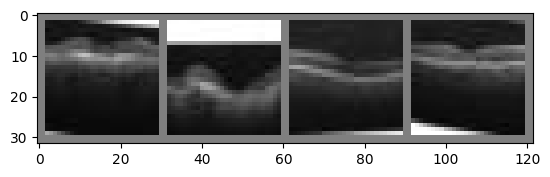

GroundTruth:  choroidal neovascularization ,choroidal neovascularization ,normal ,drusen
Predicted:  choroidal neovascularization, choroidal neovascularization, normal, drusen


In [14]:
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')
dataiter = iter(testOctloader)
images, labels = next(dataiter)
batch_size = 4
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' ,'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
mymodel = CNN_model(1,4)
mymodel.load_state_dict(torch.load(PATH))
mymodel_outputs = mymodel(images)
_, mymodel_predicted = torch.max(mymodel_outputs, 1)
print('Predicted: ', ', '.join(f'{classes[mymodel_predicted[j]]:5s}'for j in range(batch_size)))

In [15]:
mymodel.to(device)
mymodel_correct = 0
mymodel_total = 0
mymodel_testing_loss = 0.0
mymodel_test_loss = 0
mymodel_test_accuracy = 0
y_pred = []
y_test = []
mymodel_correct_pred = {classname: 0 for classname in classes}
mymodel_total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testOctloader:
        images, labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel_outputs = mymodel(images)
        mymodel_loss = mymodel_criterion(mymodel_outputs, labels)
        mymodel_testing_loss += mymodel_loss.item()
        _, mymodel_predicted = torch.max(mymodel_outputs.data, 1)
        y_pred.extend(mymodel_predicted.tolist())
        y_test.extend(labels.tolist())
        mymodel_correct += (mymodel_predicted == labels).sum().item()
        mymodel_total += labels.size(0)
        for label, mymodel_predicted in zip(labels, mymodel_predicted):
            if label == mymodel_predicted:
                mymodel_correct_pred[classes[label]] += 1
            mymodel_total_pred[classes[label]] += 1
mymodel_test_accuracy = 100 * mymodel_correct // mymodel_total
mymodel_test_loss = 100 * mymodel_testing_loss//mymodel_total
print(f'Accuracy of the cnn model on the test images: {mymodel_test_accuracy} %')
print(f'Loss of the cnn model on the test images: {mymodel_test_loss} %')


for classname, correct_count in mymodel_correct_pred.items():
    if mymodel_total_pred[classname] == 0:
        accuracy = 0.0
    else:
        accuracy = 100 * float(correct_count) / mymodel_total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the cnn model on the test images: 89 %
Accuracy for class: choroidal neovascularization is 96.3 %
Accuracy for class: diabetic macular edema is 74.6 %
Accuracy for class: drusen is 46.2 %
Accuracy for class: normal is 96.1 %


Precision [0.90516227 0.91961192 0.67477876 0.91361224]
Recall [0.96296959 0.74550562 0.46177139 0.96067999]
F1 score [0.93317154 0.82345641 0.54831461 0.93655513]


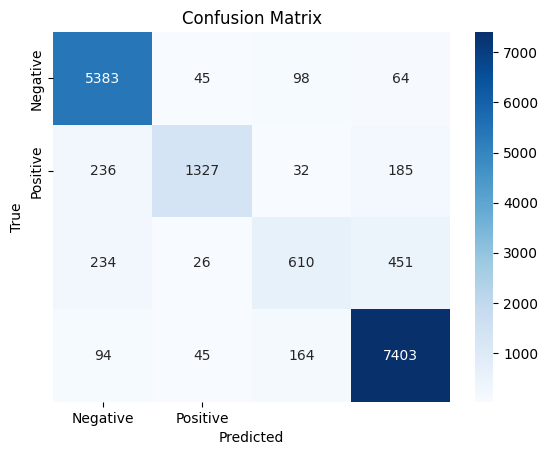

In [16]:
mymodel_precision, mymodel_recall, mymodel_f1, _ = precision_recall_fscore_support(y_test, y_pred)
print('Precision', mymodel_precision)
print('Recall', mymodel_recall)
print('F1 score', mymodel_f1)


mymodel_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(mymodel_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

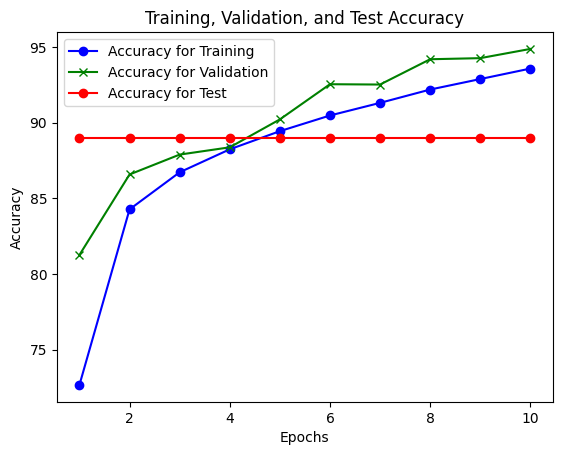

In [17]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel_train_accuracy_arr , 'b', label='Accuracy for Training', marker='o')
plt.plot(epochs_arr ,mymodel_validation_accuracy_arr , 'g', label='Accuracy for Validation', marker='x')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

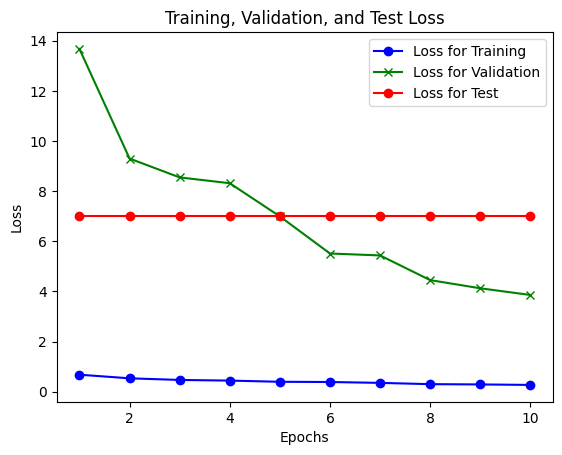

In [18]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel_train_loss_arr , 'b', label='Loss for Training', marker='o')
plt.plot(epochs_arr ,mymodel_validation_loss_arr , 'g', label='Loss for Validation', marker='x')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 1

In [19]:
class CNN_model(nn.Module):
    def __init__(self, channels, classes):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 96, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 200, 3)
        self.conv3 = nn.Conv2d(200, 280, 3)
        self.fc1 = nn.Linear(280 * 1 * 1, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

channels = 1
classes = 4
mymodel1 = CNN_model(channels,classes)

In [20]:
mymodel1_criterion = nn.CrossEntropyLoss()
mymodel1_optimizer = optim.SGD(mymodel1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
mymodel1.to(device)

CNN_model(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 280, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=280, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
)

In [21]:
mymodel1_train_accuracy_arr = []
mymodel1_train_loss_arr = []
mymodel1_validation_accuracy_arr = []
mymodel1_validation_loss_arr = []
epochs = 10
epochs_run_counter = 0
mymodel1_total_validation_loss = 0.0
mymodel1_running_loss = 0.0
for epoch in range(epochs):
    # Training
    mymodel1_total_train_loss = 0.0
    mymodel1_correct_train = 0
    mymodel1_total_train = 0
    mymodel1.train()
    for i,data in enumerate(trainOctloader):
        inputs,labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel1_optimizer.zero_grad()
        mymodel1_outputs = mymodel1(inputs)
        mymodel1_loss = mymodel1_criterion(mymodel1_outputs, labels)
        mymodel1_loss.backward()
        mymodel1_optimizer.step()
        mymodel1_running_loss += mymodel1_loss.item()
        _, predicted = torch.max(mymodel1_outputs.data, 1)
        mymodel1_total_train += labels.size(0)
        mymodel1_correct_train += (predicted == labels).sum().item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {mymodel1_running_loss / 2000:.3f}')
            mymodel1_running_loss = 0.0
    mymodel1_total_train_loss = mymodel1_running_loss*100 /mymodel1_total_train
    mymodel1_train_loss_arr.append(mymodel1_total_train_loss)
    mymodel1_train_accuracy = mymodel1_correct_train*100 / mymodel1_total_train
    mymodel1_train_accuracy_arr.append(mymodel1_train_accuracy)
    print(f'Epoch [{epoch+1}], Train Loss: {mymodel1_total_train_loss:.4f}, Train Accuracy: {mymodel1_train_accuracy:.4f}')
    # validation
    mymodel1_correct_validation = 0
    mymodel1_val_running_loss = 0.0
    mymodel1_total_validation_loss = 0.0
    mymodel1_total_val = 0
    mymodel1.eval()
    with torch.no_grad():
        for i,data in enumerate(valOctloader):
            inputs,labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze(1).long()
            mymodel1_outputs = mymodel1(inputs)
            mymodel1_loss = mymodel1_criterion(mymodel1_outputs, labels)
            _, predicted = torch.max(mymodel1_outputs.data, 1)
            mymodel1_correct_validation += (predicted == labels).sum().item()
            mymodel1_val_running_loss += mymodel1_loss.item()
            mymodel1_total_val += labels.size(0)
    mymodel1_total_validation_loss = mymodel1_val_running_loss*100/ mymodel1_total_val
    mymodel1_validation_accuracy = mymodel1_correct_validation*100 / mymodel1_total_val
    mymodel1_validation_accuracy_arr.append(mymodel1_validation_accuracy)
    mymodel1_validation_loss_arr.append(mymodel1_total_validation_loss)
    print(f'Epoch [{epoch+1}], Validation Loss: {mymodel1_total_validation_loss:.4f}, Validation Accuracy: {mymodel1_validation_accuracy:.4f}')
    epochs_run_counter+=1

print('Finished Training')

[1,  2000] training loss: 1.173
[1,  4000] training loss: 1.137
[1,  6000] training loss: 0.873
[1,  8000] training loss: 0.765
[1, 10000] training loss: 0.719
[1, 12000] training loss: 0.679
[1, 14000] training loss: 0.619
[1, 16000] training loss: 0.586
[1, 18000] training loss: 0.542
[1, 20000] training loss: 0.549
[1, 22000] training loss: 0.552
Epoch [1], Train Loss: 0.6732, Train Accuracy: 72.4632
Epoch [1], Validation Loss: 13.2819, Validation Accuracy: 81.3446
[2,  2000] training loss: 0.818
[2,  4000] training loss: 0.499
[2,  6000] training loss: 0.506
[2,  8000] training loss: 0.479
[2, 10000] training loss: 0.488
[2, 12000] training loss: 0.461
[2, 14000] training loss: 0.469
[2, 16000] training loss: 0.443
[2, 18000] training loss: 0.442
[2, 20000] training loss: 0.461
[2, 22000] training loss: 0.438
Epoch [2], Train Loss: 0.5809, Train Accuracy: 83.6157
Epoch [2], Validation Loss: 10.2159, Validation Accuracy: 85.6138
[3,  2000] training loss: 0.689
[3,  4000] training lo

In [22]:
PATH = './octmnist_mymodel.pth'
torch.save(mymodel1.state_dict(), PATH)

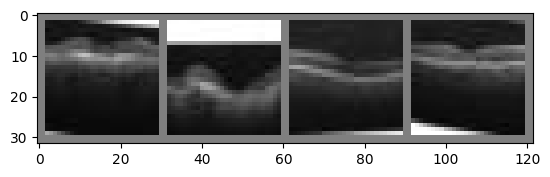

GroundTruth:  choroidal neovascularization ,choroidal neovascularization ,normal ,drusen
Predicted:  choroidal neovascularization, choroidal neovascularization, normal, drusen


In [23]:
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')
dataiter = iter(testOctloader)
images, labels = next(dataiter)
batch_size = 4
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' ,'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
mymodel1 = CNN_model(1,4)
mymodel1.load_state_dict(torch.load(PATH))
mymodel1_outputs = mymodel1(images)
_, mymodel1_predicted = torch.max(mymodel1_outputs, 1)
print('Predicted: ', ', '.join(f'{classes[mymodel1_predicted[j]]:5s}'for j in range(batch_size)))

In [24]:
mymodel1.to(device)
mymodel1_correct = 0
mymodel1_total = 0
mymodel1_testing_loss = 0.0
mymodel1_test_loss = 0
mymodel1_test_accuracy = 0
y_pred = []
y_test = []
mymodel1_correct_pred = {classname: 0 for classname in classes}
mymodel1_total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testOctloader:
        images, labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel1_outputs = mymodel1(images)
        mymodel1_loss = mymodel1_criterion(mymodel1_outputs, labels)
        mymodel1_testing_loss += mymodel1_loss.item()
        _, mymodel1_predicted = torch.max(mymodel1_outputs.data, 1)
        y_pred.extend(mymodel1_predicted.tolist())
        y_test.extend(labels.tolist())
        mymodel1_correct += (mymodel1_predicted == labels).sum().item()
        mymodel1_total += labels.size(0)
        for label, mymodel1_predicted in zip(labels, mymodel1_predicted):
            if label == mymodel1_predicted:
                mymodel1_correct_pred[classes[label]] += 1
            mymodel1_total_pred[classes[label]] += 1
mymodel1_test_accuracy = 100 * mymodel1_correct // mymodel1_total
mymodel1_test_loss = 100 * mymodel1_testing_loss// mymodel1_total
print(f'Accuracy of the cnn model on the test images: {mymodel1_test_accuracy} %')
print(f'Loss of the cnn model on the test images: {mymodel1_test_loss} %')



for classname, correct_count in mymodel1_correct_pred.items():
    if mymodel1_total_pred[classname] == 0:
        accuracy = 0.0
    else:
        accuracy = 100 * float(correct_count) / mymodel1_total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the cnn model on the test images: 88 %
Accuracy for class: choroidal neovascularization is 90.6 %
Accuracy for class: diabetic macular edema is 86.5 %
Accuracy for class: drusen is 32.1 %
Accuracy for class: normal is 97.0 %


Precision [0.92531045 0.75085324 0.74647887 0.90038545]
Recall [0.90644007 0.86516854 0.32096896 0.97002336]
F1 score [0.91577806 0.80396763 0.44891477 0.93390805]


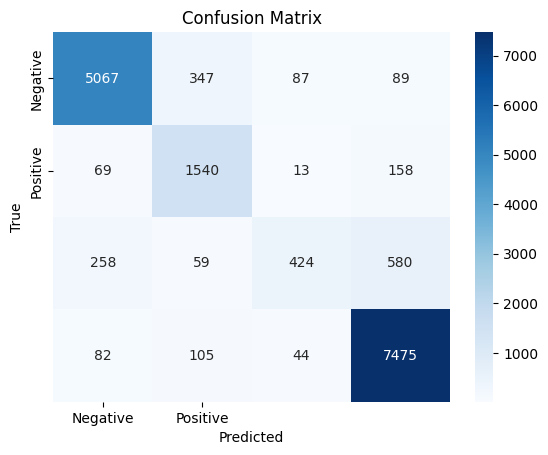

In [25]:
mymodel1_precision, mymodel1_recall, mymodel1_f1, _ = precision_recall_fscore_support(y_test, y_pred)
print('Precision', mymodel1_precision)
print('Recall', mymodel1_recall)
print('F1 score', mymodel1_f1)


mymodel1_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(mymodel1_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

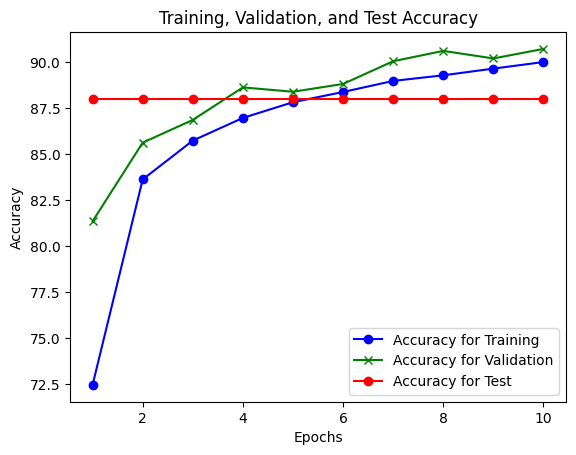

In [26]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel1_train_accuracy_arr , 'b', label='Accuracy for Training', marker='o')
plt.plot(epochs_arr ,mymodel1_validation_accuracy_arr , 'g', label='Accuracy for Validation', marker='x')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

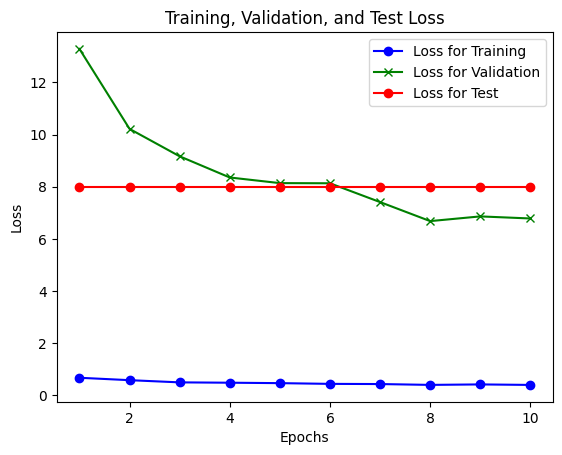

In [27]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel1_train_loss_arr , 'b', label='Loss for Training', marker='o')
plt.plot(epochs_arr ,mymodel1_validation_loss_arr , 'g', label='Loss for Validation', marker='x')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 2

In [28]:
class CNN_model(nn.Module):
    def __init__(self, channels, classes):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 96, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 200, 3)
        self.conv3 = nn.Conv2d(200, 280, 3)
        self.fc1 = nn.Linear(280 * 1 * 1, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, classes)
        self.dp = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

channels = 1
classes = 4
mymodel2 = CNN_model(channels,classes)

In [29]:
mymodel2_criterion = nn.CrossEntropyLoss()
mymodel2_optimizer = optim.SGD(mymodel2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
mymodel2.to(device)

CNN_model(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 280, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=280, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
)

In [30]:
mymodel2_train_accuracy_arr = []
mymodel2_train_loss_arr = []
mymodel2_validation_accuracy_arr = []
mymodel2_validation_loss_arr = []
epochs = 10
epochs_run_counter = 0
mymodel2_total_validation_loss = 0.0
mymodel2_running_loss = 0.0
for epoch in range(epochs):
    # Training
    mymodel2_total_train_loss = 0.0
    mymodel2_correct_train = 0
    mymodel2_total_train = 0
    mymodel2.train()
    for i,data in enumerate(trainOctloader):
        inputs,labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel2_optimizer.zero_grad()
        mymodel2_outputs = mymodel2(inputs)
        mymodel2_loss = mymodel2_criterion(mymodel2_outputs, labels)
        mymodel2_loss.backward()
        mymodel2_optimizer.step()
        mymodel2_running_loss += mymodel2_loss.item()
        _, predicted = torch.max(mymodel2_outputs.data, 1)
        mymodel2_total_train += labels.size(0)
        mymodel2_correct_train += (predicted == labels).sum().item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {mymodel2_running_loss / 2000:.3f}')
            mymodel2_running_loss = 0.0
    mymodel2_total_train_loss = mymodel2_running_loss*100 /mymodel2_total_train
    mymodel2_train_loss_arr.append(mymodel2_total_train_loss)
    mymodel2_train_accuracy = mymodel2_correct_train*100 / mymodel2_total_train
    mymodel2_train_accuracy_arr.append(mymodel2_train_accuracy)
    print(f'Epoch [{epoch+1}], Train Loss: {mymodel2_total_train_loss:.4f}, Train Accuracy: {mymodel2_train_accuracy:.4f}')
    # validation
    mymodel2_correct_validation = 0
    mymodel2_val_running_loss = 0.0
    mymodel2_total_validation_loss = 0.0
    mymodel2_total_val = 0
    mymodel2.eval()
    with torch.no_grad():
        for i,data in enumerate(valOctloader):
            inputs,labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze(1).long()
            mymodel2_outputs = mymodel2(inputs)
            mymodel2_loss = mymodel2_criterion(mymodel2_outputs, labels)
            _, predicted = torch.max(mymodel2_outputs.data, 1)
            mymodel2_correct_validation += (predicted == labels).sum().item()
            mymodel2_val_running_loss += mymodel2_loss.item()
            mymodel2_total_val += labels.size(0)
    mymodel2_total_validation_loss = mymodel2_val_running_loss*100/ mymodel2_total_val
    mymodel2_validation_accuracy = mymodel2_correct_validation*100 / mymodel2_total_val
    mymodel2_validation_accuracy_arr.append(mymodel2_validation_accuracy)
    mymodel2_validation_loss_arr.append(mymodel2_total_validation_loss)
    print(f'Epoch [{epoch+1}], Validation Loss: {mymodel2_total_validation_loss:.4f}, Validation Accuracy: {mymodel2_validation_accuracy:.4f}')
    epochs_run_counter+=1

print('Finished Training')

[1,  2000] training loss: 1.175
[1,  4000] training loss: 1.147
[1,  6000] training loss: 0.934
[1,  8000] training loss: 0.783
[1, 10000] training loss: 0.746
[1, 12000] training loss: 0.707
[1, 14000] training loss: 0.674
[1, 16000] training loss: 0.632
[1, 18000] training loss: 0.593
[1, 20000] training loss: 0.579
[1, 22000] training loss: 0.538
Epoch [1], Train Loss: 0.7171, Train Accuracy: 71.2158
Epoch [1], Validation Loss: 13.0042, Validation Accuracy: 82.4065
[2,  2000] training loss: 0.848
[2,  4000] training loss: 0.529
[2,  6000] training loss: 0.526
[2,  8000] training loss: 0.497
[2, 10000] training loss: 0.468
[2, 12000] training loss: 0.479
[2, 14000] training loss: 0.483
[2, 16000] training loss: 0.475
[2, 18000] training loss: 0.473
[2, 20000] training loss: 0.458
[2, 22000] training loss: 0.447
Epoch [2], Train Loss: 0.5800, Train Accuracy: 83.3305
Epoch [2], Validation Loss: 10.6842, Validation Accuracy: 85.1187
[3,  2000] training loss: 0.704
[3,  4000] training lo

In [31]:
PATH = './octmnist_mymodel.pth'
torch.save(mymodel2.state_dict(), PATH)

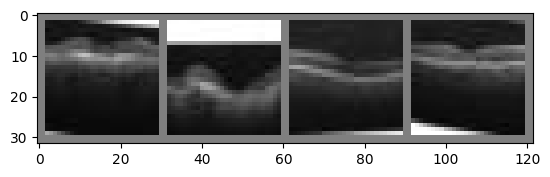

GroundTruth:  choroidal neovascularization ,choroidal neovascularization ,normal ,drusen
Predicted:  choroidal neovascularization, choroidal neovascularization, normal, drusen


In [32]:
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')
dataiter = iter(testOctloader)
images, labels = next(dataiter)
batch_size = 4
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' ,'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
mymodel2 = CNN_model(1,4)
mymodel2.load_state_dict(torch.load(PATH))
mymodel2_outputs = mymodel2(images)
_, mymodel2_predicted = torch.max(mymodel2_outputs, 1)
print('Predicted: ', ', '.join(f'{classes[mymodel2_predicted[j]]:5s}'for j in range(batch_size)))

In [33]:
mymodel2.to(device)
mymodel2_correct = 0
mymodel2_total = 0
mymodel2_testing_loss = 0.0
mymodel2_test_loss = 0
mymodel2_test_accuracy = 0
y_pred = []
y_test = []
mymodel2_correct_pred = {classname: 0 for classname in classes}
mymodel2_total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testOctloader:
        images, labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel2_outputs = mymodel2(images)
        mymodel2_loss = mymodel2_criterion(mymodel2_outputs, labels)
        mymodel2_testing_loss += mymodel2_loss.item()
        _, mymodel2_predicted = torch.max(mymodel2_outputs.data, 1)
        y_pred.extend(mymodel2_predicted.tolist())
        y_test.extend(labels.tolist())
        mymodel2_correct += (mymodel2_predicted == labels).sum().item()
        mymodel2_total += labels.size(0)
        for label, mymodel2_predicted in zip(labels, mymodel2_predicted):
            if label == mymodel2_predicted:
                mymodel2_correct_pred[classes[label]] += 1
            mymodel2_total_pred[classes[label]] += 1
mymodel2_test_accuracy = 100 * mymodel2_correct // mymodel2_total
mymodel2_test_loss = 100 * mymodel2_testing_loss//mymodel2_total
print(f'Accuracy of the cnn model on the test images: {mymodel2_test_accuracy} %')
print(f'Loss of the cnn model on the test images: {mymodel2_test_loss} %')

for classname, correct_count in mymodel2_correct_pred.items():
    if mymodel2_total_pred[classname] == 0:
        accuracy = 0.0
    else:
        accuracy = 100 * float(correct_count) / mymodel2_total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the cnn model on the test images: 88 %
Accuracy for class: choroidal neovascularization is 89.9 %
Accuracy for class: diabetic macular edema is 84.2 %
Accuracy for class: drusen is 50.2 %
Accuracy for class: normal is 95.6 %


Precision [0.94528018 0.83037694 0.56909871 0.90850801]
Recall [0.89928444 0.84157303 0.50189251 0.95613807]
F1 score [0.92170884 0.8359375  0.53338697 0.93171472]


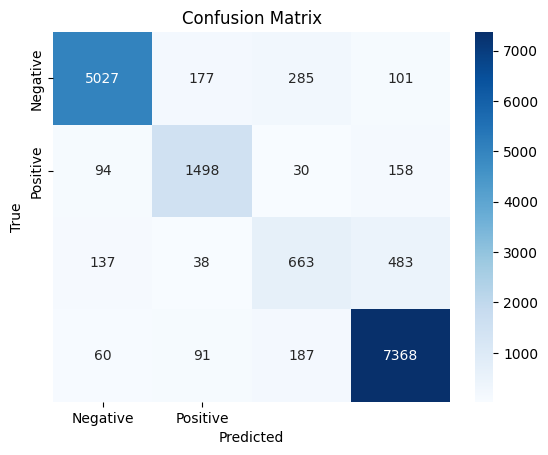

In [34]:
mymodel2_precision, mymodel2_recall, mymodel2_f1, _ = precision_recall_fscore_support(y_test, y_pred)
print('Precision', mymodel2_precision)
print('Recall', mymodel2_recall)
print('F1 score', mymodel2_f1)


mymodel2_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(mymodel2_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

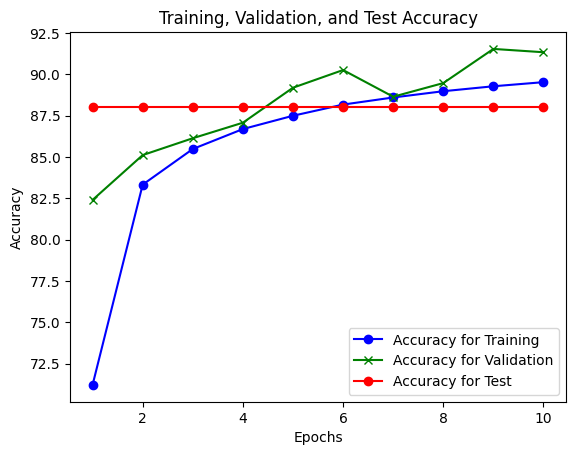

In [35]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel2_train_accuracy_arr , 'b', label='Accuracy for Training', marker='o')
plt.plot(epochs_arr ,mymodel2_validation_accuracy_arr , 'g', label='Accuracy for Validation', marker='x')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

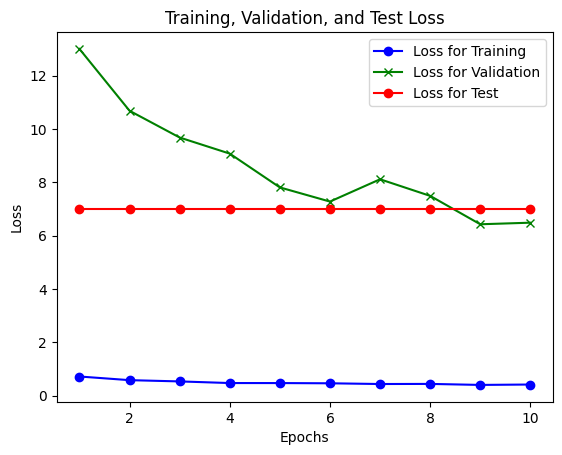

In [36]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel2_train_loss_arr , 'b', label='Loss for Training', marker='o')
plt.plot(epochs_arr ,mymodel2_validation_loss_arr , 'g', label='Loss for Validation', marker='x')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 3

In [37]:
class CNN_model(nn.Module):
    def __init__(self, channels, classes):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 96, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 200, 3)
        self.conv3 = nn.Conv2d(200, 280, 3)
        self.fc1 = nn.Linear(280 * 1 * 1, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, classes)
        self.dp = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

channels = 1
classes = 4
mymodel3 = CNN_model(channels,classes)

In [38]:
mymodel3_criterion = nn.CrossEntropyLoss()
mymodel3_optimizer = optim.SGD(mymodel3.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
mymodel3.to(device)

CNN_model(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 200, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(200, 280, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=280, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
)

In [39]:
mymodel3_train_accuracy_arr = []
mymodel3_train_loss_arr = []
mymodel3_validation_accuracy_arr = []
mymodel3_validation_loss_arr = []
epochs = 10
epochs_run_counter = 0
min_validation_loss = float('inf')
counter = 0
mymodel3_total_validation_loss = 0.0
mymodel3_running_loss = 0.0
for epoch in range(epochs):
    # Training
    mymodel3_total_train_loss = 0.0
    mymodel3_correct_train = 0
    mymodel3_total_train = 0
    mymodel3.train()
    for i,data in enumerate(trainOctloader):
        inputs,labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel3_optimizer.zero_grad()
        mymodel3_outputs = mymodel3(inputs)
        mymodel3_loss = mymodel3_criterion(mymodel3_outputs, labels)
        mymodel3_loss.backward()
        mymodel3_optimizer.step()
        mymodel3_running_loss += mymodel3_loss.item()
        _, predicted = torch.max(mymodel3_outputs.data, 1)
        mymodel3_total_train += labels.size(0)
        mymodel3_correct_train += (predicted == labels).sum().item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {mymodel3_running_loss / 2000:.3f}')
            mymodel3_running_loss = 0.0
    mymodel3_total_train_loss = mymodel3_running_loss*100 /mymodel3_total_train
    mymodel3_train_loss_arr.append(mymodel3_total_train_loss)
    mymodel3_train_accuracy = mymodel3_correct_train*100 / mymodel3_total_train
    mymodel3_train_accuracy_arr.append(mymodel3_train_accuracy)
    print(f'Epoch [{epoch+1}], Train Loss: {mymodel3_total_train_loss:.4f}, Train Accuracy: {mymodel3_train_accuracy:.4f}')
    # validation
    mymodel3_correct_validation = 0
    mymodel3_val_running_loss = 0.0
    mymodel3_total_validation_loss = 0.0
    mymodel3_total_val = 0
    mymodel3.eval()
    with torch.no_grad():
        for i,data in enumerate(valOctloader):
            inputs,labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze(1).long()
            mymodel3_outputs = mymodel3(inputs)
            mymodel3_loss = mymodel3_criterion(mymodel3_outputs, labels)
            _, predicted = torch.max(mymodel3_outputs.data, 1)
            mymodel3_correct_validation += (predicted == labels).sum().item()
            mymodel3_val_running_loss += mymodel3_loss.item()
            mymodel3_total_val += labels.size(0)
    mymodel3_total_validation_loss = mymodel3_val_running_loss*100/ mymodel3_total_val
    mymodel3_validation_accuracy = mymodel3_correct_validation*100 / mymodel3_total_val
    mymodel3_validation_accuracy_arr.append(mymodel3_validation_accuracy)
    mymodel3_validation_loss_arr.append(mymodel3_total_validation_loss)
    print(f'Epoch [{epoch+1}], Validation Loss: {mymodel3_total_validation_loss:.4f}, Validation Accuracy: {mymodel3_validation_accuracy:.4f}')
    epochs_run_counter+=1
    #Early stopping
    if mymodel3_total_validation_loss < min_validation_loss:
        min_validation_loss = mymodel3_total_validation_loss
        counter = 0
    else:
        counter +=1
    if counter == 6:
        break

print('Finished Training')

[1,  2000] training loss: 1.182
[1,  4000] training loss: 1.147
[1,  6000] training loss: 0.923
[1,  8000] training loss: 0.781
[1, 10000] training loss: 0.715
[1, 12000] training loss: 0.707
[1, 14000] training loss: 0.671
[1, 16000] training loss: 0.642
[1, 18000] training loss: 0.589
[1, 20000] training loss: 0.579
[1, 22000] training loss: 0.560
Epoch [1], Train Loss: 0.7387, Train Accuracy: 71.1447
Epoch [1], Validation Loss: 15.5104, Validation Accuracy: 78.9481
[2,  2000] training loss: 0.858
[2,  4000] training loss: 0.509
[2,  6000] training loss: 0.508
[2,  8000] training loss: 0.509
[2, 10000] training loss: 0.489
[2, 12000] training loss: 0.490
[2, 14000] training loss: 0.477
[2, 16000] training loss: 0.471
[2, 18000] training loss: 0.464
[2, 20000] training loss: 0.463
[2, 22000] training loss: 0.452
Epoch [2], Train Loss: 0.5867, Train Accuracy: 83.2928
Epoch [2], Validation Loss: 10.9078, Validation Accuracy: 84.5734
[3,  2000] training loss: 0.689
[3,  4000] training lo

In [40]:
PATH = './octmnist_mymodel.pth'
torch.save(mymodel3.state_dict(), PATH)

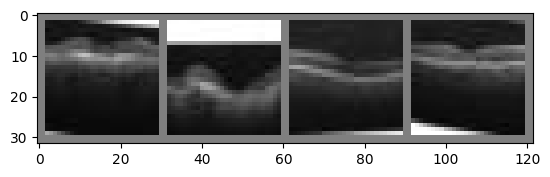

GroundTruth:  choroidal neovascularization ,choroidal neovascularization ,normal ,drusen
Predicted:  choroidal neovascularization, choroidal neovascularization, normal, choroidal neovascularization


In [41]:
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')
dataiter = iter(testOctloader)
images, labels = next(dataiter)
batch_size = 4
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' ,'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
mymodel3 = CNN_model(1,4)
mymodel3.load_state_dict(torch.load(PATH))
mymodel3_outputs = mymodel3(images)
_, mymodel3_predicted = torch.max(mymodel3_outputs, 1)
print('Predicted: ', ', '.join(f'{classes[mymodel3_predicted[j]]:5s}'for j in range(batch_size)))

In [42]:
mymodel3.to(device)
mymodel3_correct = 0
mymodel3_total = 0
mymodel3_testing_loss = 0.0
mymodel3_test_loss = 0
mymodel3_test_accuracy = 0
y_pred = []
y_test = []
mymodel3_correct_pred = {classname: 0 for classname in classes}
mymodel3_total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testOctloader:
        images, labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze(1).long()
        mymodel3_outputs = mymodel3(images)
        mymodel3_loss = mymodel3_criterion(mymodel3_outputs, labels)
        mymodel3_testing_loss += mymodel3_loss.item()
        _, mymodel3_predicted = torch.max(mymodel3_outputs.data, 1)
        y_pred.extend(mymodel3_predicted.tolist())
        y_test.extend(labels.tolist())
        mymodel3_correct += (mymodel3_predicted == labels).sum().item()
        mymodel3_total += labels.size(0)
        for label, mymodel3_predicted in zip(labels, mymodel3_predicted):
            if label == mymodel3_predicted:
                mymodel3_correct_pred[classes[label]] += 1
            mymodel3_total_pred[classes[label]] += 1
mymodel3_test_accuracy = 100 * mymodel3_correct // mymodel3_total
mymodel3_test_loss = 100 * mymodel3_testing_loss // mymodel3_total
print(f'Accuracy of the cnn model on the test images: {mymodel3_test_accuracy} %')
print(f'Loss of the cnn model on the test images: {mymodel3_test_loss} %')

for classname, correct_count in mymodel3_correct_pred.items():
    if mymodel3_total_pred[classname] == 0:
        accuracy = 0.0
    else:
        accuracy = 100 * float(correct_count) / mymodel3_total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the cnn model on the test images: 88 %
Accuracy for class: choroidal neovascularization is 94.7 %
Accuracy for class: diabetic macular edema is 79.9 %
Accuracy for class: drusen is 16.9 %
Accuracy for class: normal is 97.8 %


Precision [0.90122616 0.86234081 0.81386861 0.87642409]
Recall [0.94669052 0.7988764  0.16881151 0.97832858]
F1 score [0.92339906 0.82939633 0.27962382 0.92457689]


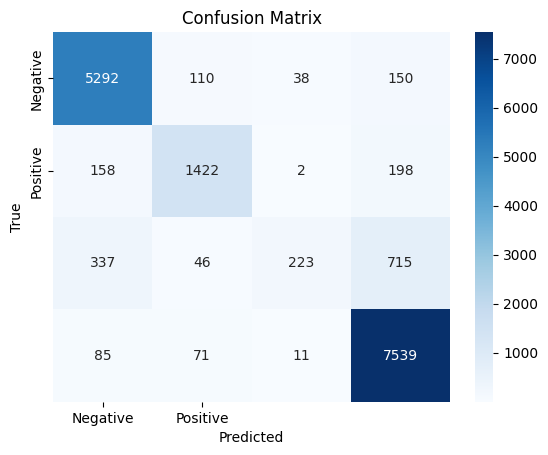

In [43]:
mymodel3_precision, mymodel3_recall, mymodel3_f1, _ = precision_recall_fscore_support(y_test, y_pred)
print('Precision', mymodel3_precision)
print('Recall', mymodel3_recall)
print('F1 score', mymodel3_f1)


mymodel3_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(mymodel3_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

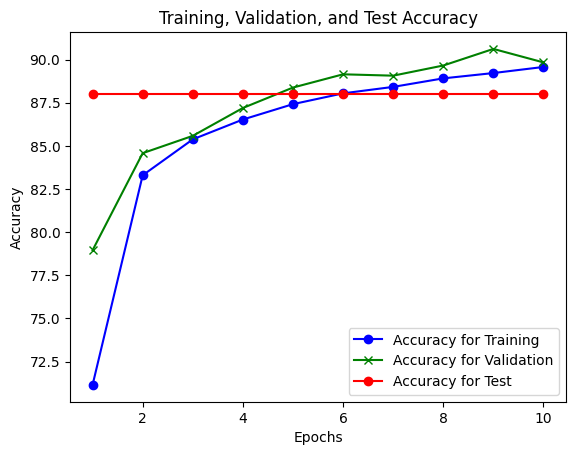

In [44]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel3_train_accuracy_arr , 'b', label='Accuracy for Training', marker='o')
plt.plot(epochs_arr ,mymodel3_validation_accuracy_arr , 'g', label='Accuracy for Validation', marker='x')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

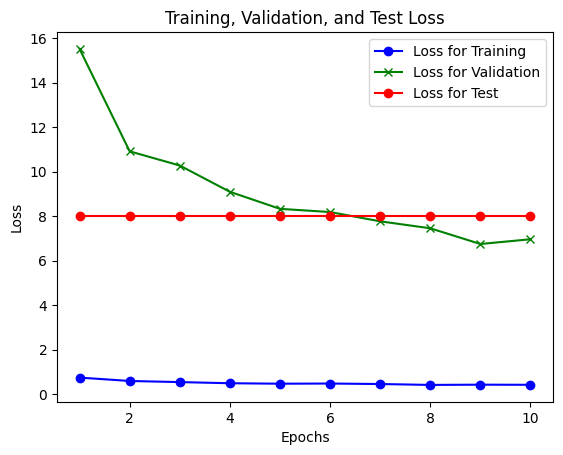

In [45]:
epochs_arr = range(1, epochs_run_counter+1)
plt.plot(epochs_arr ,mymodel3_train_loss_arr , 'b', label='Loss for Training', marker='o')
plt.plot(epochs_arr ,mymodel3_validation_loss_arr , 'g', label='Loss for Validation', marker='x')
vplt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()